# Llama Product Pricer
## Base Model Evaluation :

In [1]:
# pip installs - ignore the error message!

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib

In [1]:
# imports

import os
import re
import math
from tqdm import tqdm
# from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

# Constants

BASE_MODEL = LLAMA_3_1
HF_USER = "imonghose"
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

### Log in to HuggingFace

If you don't already have a HuggingFace account, visit https://huggingface.co to sign up and create a token.

Then select the Secrets for this Notebook by clicking on the key icon in the left, and add a new secret called `HF_TOKEN` with the value as your token.

In [3]:
# Log in to HuggingFace

import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load .env file
load_dotenv()

# Get the token
hf_token = os.getenv("HF_TOKEN")

# ✅ Check if token loaded
if hf_token is None or hf_token.strip() == "":
    raise ValueError("❌ Hugging Face token not found. Please check your .env file.")
else:
    print("✅ Hugging Face token loaded successfully!")

# Login
login(hf_token, add_to_git_credential=True)

✅ Hugging Face token loaded successfully!


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# Check number of tokens created by tokenizers for upto 4 digit numbers
def investigate_tokenizer(model_name):
  print("Investigating tokenizer for", model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  for number in [0, 1, 10, 100, 999, 1000]:
    tokens = tokenizer.encode(str(number), add_special_tokens=False)
    print(f"The tokens for {number}: {tokens}")

In [5]:
# Now we will try this with each model: LLAMA_3_1, QWEN_2_5, GEMMA_2, PHI_3

investigate_tokenizer(PHI_3)

Investigating tokenizer for microsoft/Phi-3-medium-4k-instruct
The tokens for 0: [29871, 29900]
The tokens for 1: [29871, 29896]
The tokens for 10: [29871, 29896, 29900]
The tokens for 100: [29871, 29896, 29900, 29900]
The tokens for 999: [29871, 29929, 29929, 29929]
The tokens for 1000: [29871, 29896, 29900, 29900, 29900]


In [6]:
investigate_tokenizer(LLAMA_3_1)

Investigating tokenizer for meta-llama/Meta-Llama-3.1-8B
The tokens for 0: [15]
The tokens for 1: [16]
The tokens for 10: [605]
The tokens for 100: [1041]
The tokens for 999: [5500]
The tokens for 1000: [1041, 15]


# Load our data

In [ ]:
# Load pre-curated dataset
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [8]:
# Text is the prompt + product description + price (if training, else no price)
# Price is the target value
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $",
 'price': 374.41}

# Prepare our Base Llama Model for evaluation

Load our base model with 4 bit quantization and try out 1 example

In [ ]:
## pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token # Pad with eos token
tokenizer.padding_side = "right" # Pad on the right

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5.6 GB


In [12]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [13]:
extract_price("Price is $999 blah blah so cheap")

999.0

In [14]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda") # Builds an attention mask of all 1s (no padding to ignore). This says “every token is real; don’t mask anything.”
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("Full response:", response)
    return extract_price(response)

In [20]:
test[6]

{'text': 'How much does this cost to the nearest dollar?\n\nSK6241 - Stinger 4 Gauge 6000 Series Power Amplifier Installation Kit\nAmplifier installation kits can save you time & money when installing an amplifier in your vehicle. Instead of purchasing everything you need separately like power/ground cables, remote turn-on cable, fuse blocks, fuses, and more, you can get an amp kit that already has the cables & accessories in one package. Amplifier wiring kits come in various gauge configurations depending on the wattage of your sound system and include all the necessary components you need to successfully install an amplifier. This Stinger 4 AWG 6000 Series Power Amplifier Wiring Kit includes all the necessary hardware and wire to power one amplifier and is designed specifically for car audio systems up to 1750 watts. The included premium power\n\nPrice is $',
 'price': 101.79}

In [19]:
model_predict(test[6]['text'])

Full response: How much does this cost to the nearest dollar?

SK6241 - Stinger 4 Gauge 6000 Series Power Amplifier Installation Kit
Amplifier installation kits can save you time & money when installing an amplifier in your vehicle. Instead of purchasing everything you need separately like power/ground cables, remote turn-on cable, fuse blocks, fuses, and more, you can get an amp kit that already has the cables & accessories in one package. Amplifier wiring kits come in various gauge configurations depending on the wattage of your sound system and include all the necessary components you need to successfully install an amplifier. This Stinger 4 AWG 6000 Series Power Amplifier Wiring Kit includes all the necessary hardware and wire to power one amplifier and is designed specifically for car audio systems up to 1750 watts. The included premium power

Price is $89.99.


89.99

# Evaluation!

Trying out our base Llama 3.1 model against the Test dataset

In [21]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

Full response: How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $1,000.
1: Guess: $1,000.00 Truth: $374.41 Error: $625.59 SLE: 0.96 Item: OEM AC Compressor w/...
Full response: How much does this cost to the nearest do

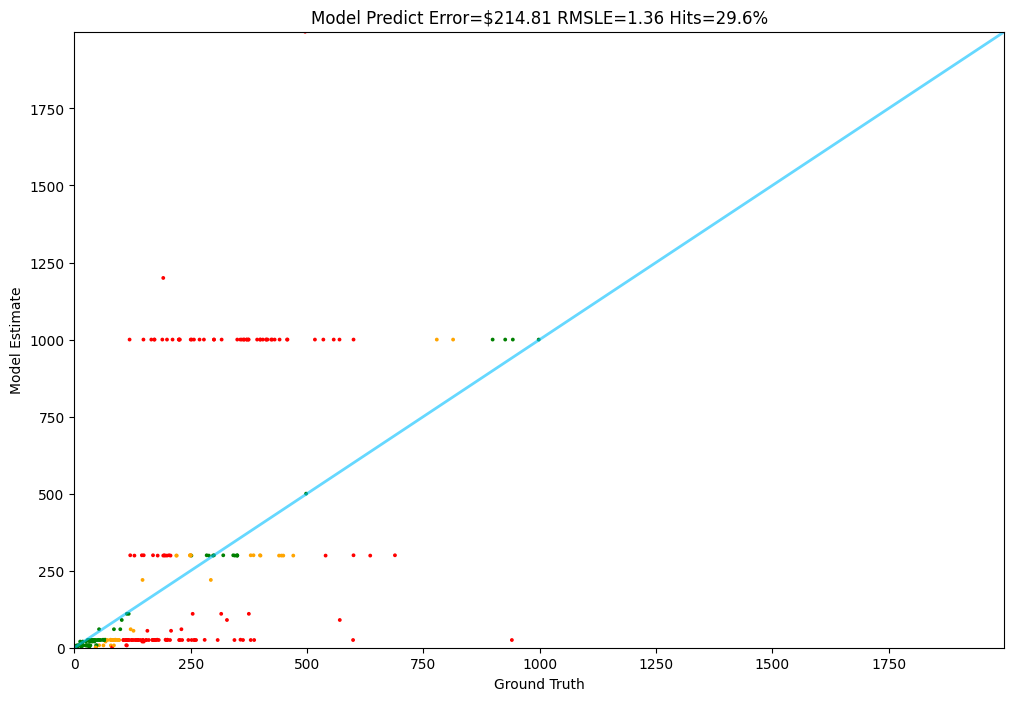

In [22]:
Tester.test(model_predict, test)